In [1]:
%who

Interactive namespace is empty.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib
import seaborn as sns

# getting the spatial plotting function from another directory
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs
%run -i drought_2017to2019/dataInfo_and_functions.py

import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from datetime import datetime

def convert_to_date(x):
    '''
    x is a string; may contain HH:MM:SS
    '''
    if len(x) > 11:
        x_date = np.datetime64(pd.Timestamp(datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).date())
    else:
        x_date = np.datetime64(pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')).date())
    return x_date

In [3]:
state =  'SA' #'NSW'

# 'VIC', 'ACT': no data satisfying the criterion
# QLD: continuous data only after year 2010
# SA: continuous data only after year 2015

# output file
# file_wl_bores_subset = '/g/data/w97/ad9701/drought_2017to2020/borewell/bore_selected/NSW_subset_bores.csv'

gw_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/shp_' + state + '/level_' + state + '.csv'
df_gw = pd.read_csv(gw_file)

###############################
# Remove low quality data
###############################
# this would need to be checkd for each state as the quality flags are different
uniq_qflag = pd.unique(df_gw['quality_flag'])

In [4]:
uniq_qflag

array(['quality-A', 'quality-B', 'quality-F'], dtype=object)

In [5]:
df_gw = df_gw[df_gw['quality_flag'].isin(['1', 'quality-A', np.nan])]

###############################
# Select bore containing water level measurements and add lat-longs of the bores in the drought focus region
###############################

bore_select = '/g/data/w97/ad9701/drought_2017to2020/borewell/bore_selected/' + state + '_Bore_select.csv'
df_bore = pd.read_csv(bore_select)

# select only bores containing water level measurements & get their lat-longs from the selected bore file
df_bore_wl = df_bore[df_bore['WaterLevel']==1]

df_gw['Longitude'] = df_gw['hydroid'].map(df_bore.set_index('HydroID')['Longitude'])
df_gw['Latitude'] = df_gw['hydroid'].map(df_bore.set_index('HydroID')['Latitude'])

# remove measurements that are outside the focus region
df_gw = df_gw[~np.isnan(df_gw['Latitude'])]

# save the lat-lons of the water level bores
# df_gw_latlon = df_gw[['Latitude', 'Longitude']]
# df_gw_latlon.drop_duplicates().to_csv(file_wl_bores_subset)

df_gw['time'] = df_gw['bore_date'].apply(convert_to_date)
# df_gw = df_gw.set_index(['time'])
# da_gw = df_gw.to_xarray().sortby('time')

df_gw = df_gw.set_index(['hydroid', 'time', 'obs_point_datum'])

# duplicate index values, https://stackoverflow.com/questions/54028365/what-does-this-mean-xarray-error-cannot-handle-a-non-unique-multi-index
df_gw = df_gw.groupby(level=df_gw.index.names).mean()
da_gw = df_gw.to_xarray().sortby('time')
da_gw

<xarray.Dataset>
Dimensions:          (hydroid: 5299, time: 7790, obs_point_datum: 3)
Coordinates:
  * hydroid          (hydroid) int64 30000026 30000027 ... 30199316 30199356
  * time             (time) datetime64[ns] 1907-01-01 1909-07-22 ... 2021-07-14
  * obs_point_datum  (obs_point_datum) object 'DTW' 'RSWL (mAHD)' 'SWL'
Data variables:
    bore_id          (hydroid, time, obs_point_datum) float64 nan nan ... nan
    result           (hydroid, time, obs_point_datum) float64 nan nan ... nan
    Longitude        (hydroid, time, obs_point_datum) float64 nan nan ... nan
    Latitude         (hydroid, time, obs_point_datum) float64 nan nan ... nan

### Using the saved data to subset wells that have sufficient records

In [5]:
%who

BIGGER_SIZE	 LATITUDE_FORMATTER	 LONGITUDE_FORMATTER	 MEDIUM_SIZE	 SMALL_SIZE	 add_cyclic_point	 agcd_info	 alldata_dict	 awra_info	 
ccrs	 cfeature	 chirps_info	 clim_time_slice	 convert_to_date	 cticker	 da_gw	 da_gw_clim_count	 da_gw_drought_count	 
da_gw_sel	 da_gw_sel_dataFrac	 dataAvailFrac	 datetime	 draw_spatial_plot	 draw_spatial_plot_12panels	 draw_spatial_plot_3panels	 draw_spatial_plot_addcontours	 draw_spatial_plot_addsh	 
era5land_info	 esacci_info	 get_da	 get_da_simple	 gleam_info	 glob	 gpd	 logicArray	 matplotlib	 
mswep_info	 mticker	 myfuncs	 new_path	 np	 out_ncfile	 pd	 plt	 regrid_all_from_list	 
save_monthly_data	 save_monthly_data_byyear	 sns	 state	 sys	 time_sel	 totDays	 xe	 xr	 



In [3]:
state = 'QLD'

# read in the saved data
out_ncfile = '/g/data/w97/ad9701/drought_2017to2020/borewell/selected_level_' + state + '.nc'
# da_gw.to_netcdf(out_ncfile)
da_gw = xr.open_dataset(out_ncfile)
da_gw.load()

# select borewells that have some data in 2017 to 2019
time_sel = slice('2017-01-01', '2019-12-31')
da_gw_drought_count = da_gw['result'].sel(time = time_sel).count(['time', 'obs_point_datum'])
da_gw_sel = da_gw.where(da_gw_drought_count > 0)

# also look at data available to calculate the climatology for anomalies
clim_time_slice = slice('2010-01-01', None)
totDays = len(pd.date_range(start='2010-01-01', end='2020-12-31', freq='D'))
da_gw_sel.sel(time = clim_time_slice)

da_gw_clim_count = da_gw['result'].sel(time = clim_time_slice).count(['time'])
dataAvailFrac = da_gw_clim_count.max('obs_point_datum')/totDays

logicArray = dataAvailFrac > 0.8
select_time_slice = slice('1996-01-01', None)
da_gw_sel_dataFrac = da_gw.sel(time = select_time_slice).where(da_gw_drought_count > 30).isel(hydroid = logicArray)

# kwargs = {'legend': None}
# da_gw_sel_dataFrac.plot(col = 'obs_point_datum', size = 5, aspect=2, hue = 'hydroid', label=None) #, kwargs)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [5]:
subset_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_' + state + '_80perc_post2010_longrec.nc'
da_gw_sel_dataFrac.to_netcdf(subset_file)

In [7]:
subset_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_' + state + '.nc'
da_gw_sel_dataFrac.to_netcdf(subset_file)

In [8]:
# save the latlongs to a csv file
csv_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_' + state + '_v1.csv'
df_latlon = pd.DataFrame({'lat': da_gw_sel_dataFrac['Latitude'].mean(['time', 'obs_point_datum']).values,
                          'lon': da_gw_sel_dataFrac['Longitude'].mean(['time', 'obs_point_datum']).values,
                          'hydroid': da_gw_sel_dataFrac.hydroid.values})
df_latlon.to_csv(csv_file)

In [4]:
da_gw_sel_dataFrac

<xarray.Dataset>
Dimensions:          (hydroid: 13, time: 9352, obs_point_datum: 3)
Coordinates:
  * hydroid          (hydroid) int64 40133180 40134998 ... 40149458 40152840
  * time             (time) datetime64[ns] 1996-01-01 1996-01-02 ... 2021-09-02
  * obs_point_datum  (obs_point_datum) object 'DTW' 'RSWL (mAHD)' 'SWL'
Data variables:
    result           (hydroid, time, obs_point_datum) float64 nan nan ... nan
    Longitude        (hydroid, time, obs_point_datum) float64 nan nan ... nan
    Latitude         (hydroid, time, obs_point_datum) float64 nan nan ... nan

In [9]:
da_gw_sel_dataFrac1 = da_gw_sel_dataFrac.copy(deep=True)#.time[-10::]

In [36]:
# Only for NSW: The original array containing 94 hydroid (data from 199601-current) are saved into da_gw_sel_dataFrac1
# the 


hydroid_new = da_gw_sel_dataFrac.hydroid.values
hydroid_orig = da_gw_sel_dataFrac1.hydroid.values

hydroid_new_update = list(set(hydroid_new) - set(hydroid_orig))

da_gw_sel_dataFrac_new = da_gw_sel_dataFrac.sel(hydroid = hydroid_new_update)

In [39]:
subset_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_' + state + '_80perc_post2010.nc'
da_gw_sel_dataFrac_new.to_netcdf(subset_file)

### Scratch Space

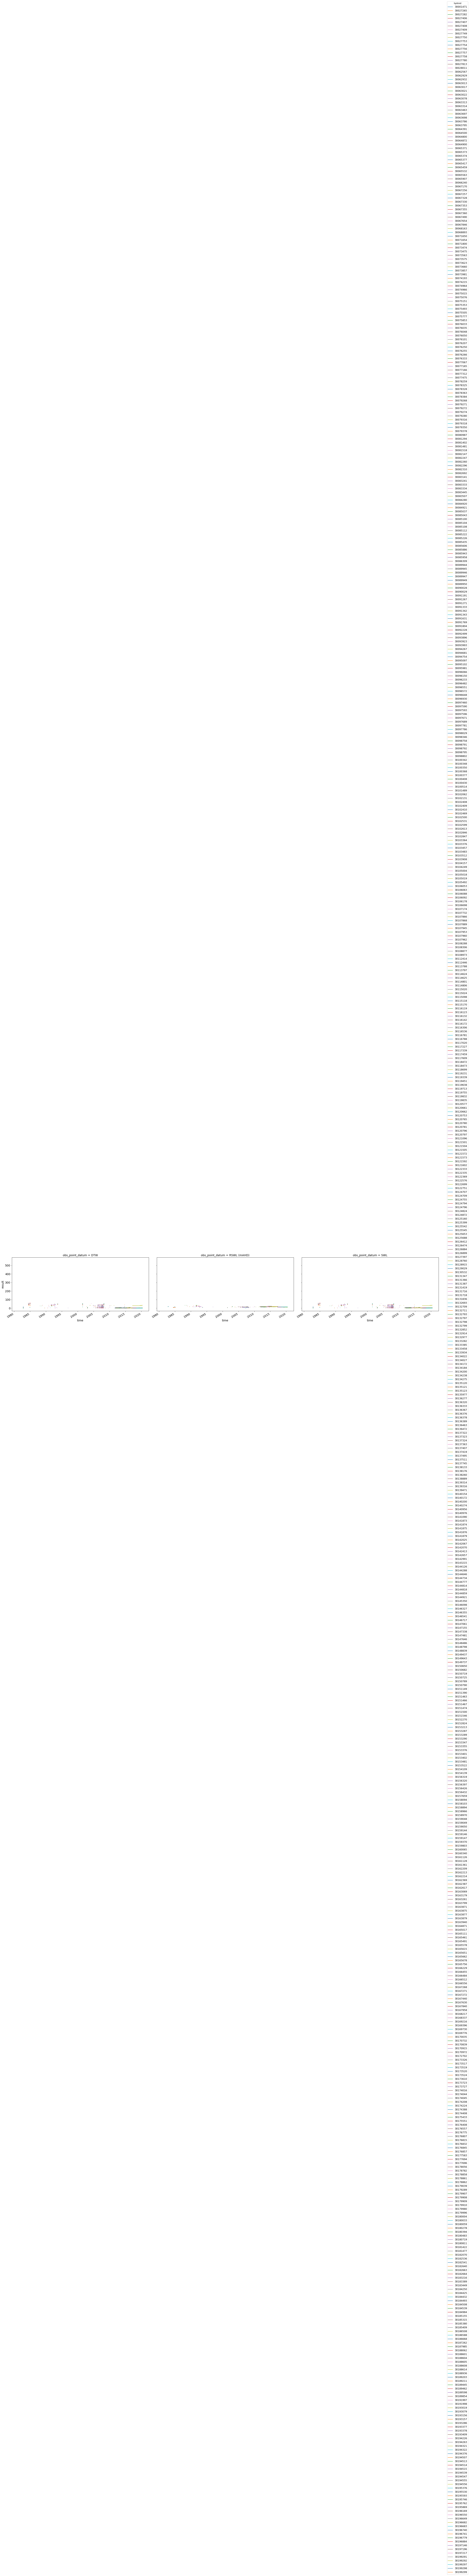

In [10]:
boolSel = da_gw_drought_count.values > 0
da_gw['result'].sel(time = clim_time_slice).isel(hydroid = boolSel).plot(col = 'obs_point_datum', size = 5, aspect=2, hue = 'hydroid', label=None)

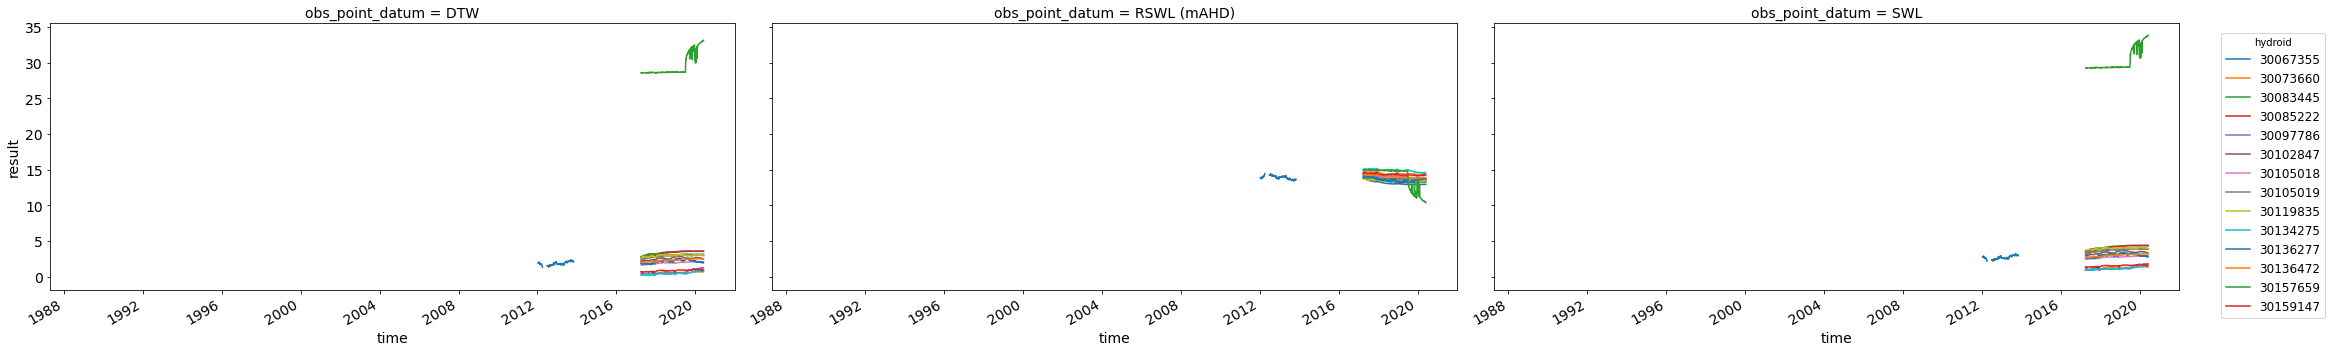

In [17]:
da_gw_sel_dataFrac['result'].plot(col = 'obs_point_datum', size = 5, aspect=2, hue = 'hydroid', label=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


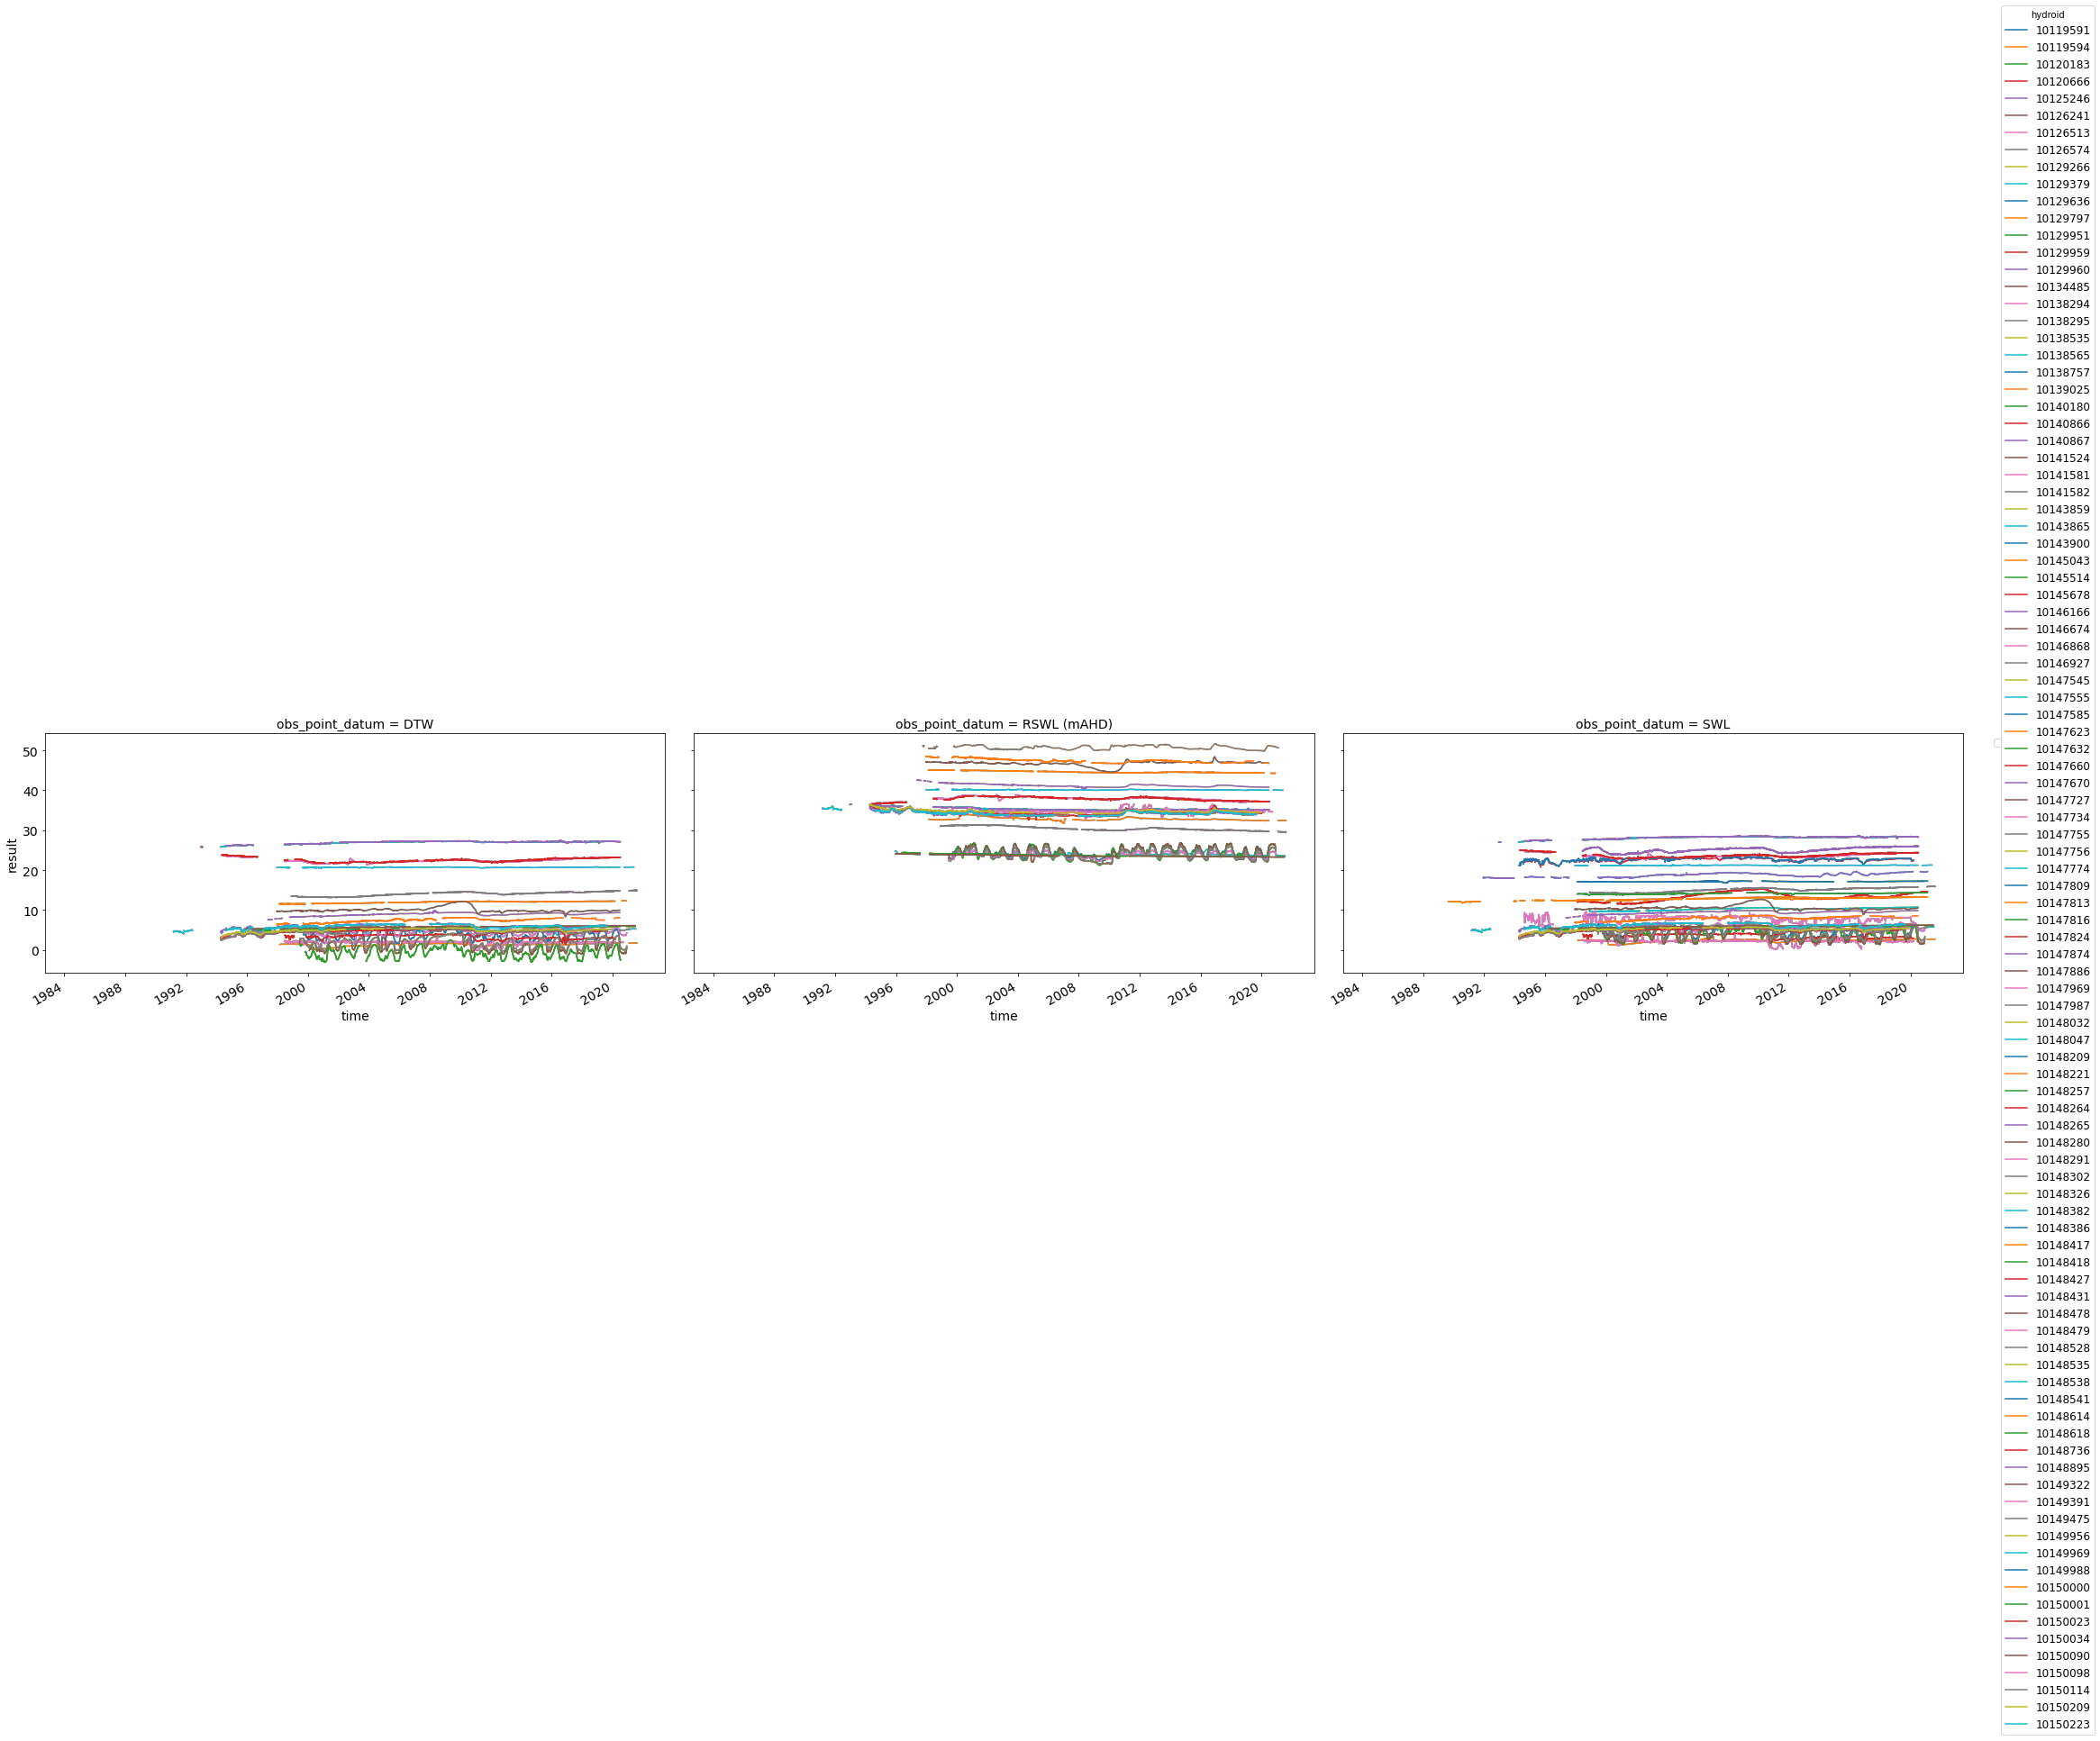

In [ ]:
kwargs = {'legend': None}
da_gw_sel_dataFrac.plot(col = 'obs_point_datum', size = 5, aspect=2, hue = 'hydroid', label=None) #, kwargs)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


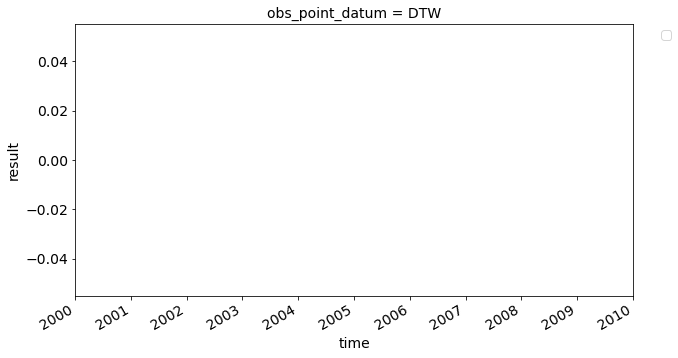

In [17]:
da_gw_sel['result'][:,:,0].sel(time = slice('1981-01-01', '2020-05-31')).plot(size = 5, aspect=2, hue = 'hydroid', label=None) #, kwargs)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [8]:
da_gw_sel['result']

<xarray.DataArray 'result' (hydroid: 5982, time: 20643, obs_point_datum: 3)>
array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]])
Coordinates:
  * hydroid          (hydroid) int64 40000344 40000421 ... 40166642 40166643
  * time             (time) datetime64[ns] 1879-01-01 1886-12-17 ... 2021-09-02
  * obs_point_datum  (obs_point_datum) object 'DTW' 'RSWL (mAHD)' 'SWL'

In [14]:
da_gw['result']

<xarray.DataArray 'result' (hydroid: 15, time: 3765, obs_point_datum: 1)>
array([[[1.65],
        [1.62],
        [1.62],
        ...,
        [ nan],
        [ nan],
        [ nan]],

       [[1.41],
        [1.42],
        [1.35],
        ...,
        [ nan],
        [ nan],
        [ nan]],

       [[8.22],
        [8.22],
        [8.25],
        ...,
...
        ...,
        [ nan],
        [ nan],
        [ nan]],

       [[ nan],
        [ nan],
        [ nan],
        ...,
        [ nan],
        [ nan],
        [ nan]],

       [[ nan],
        [ nan],
        [ nan],
        ...,
        [ nan],
        [ nan],
        [ nan]]])
Coordinates:
  * hydroid          (hydroid) int64 80000000 80000001 ... 80000014 80000015
  * time             (time) datetime64[ns] 2005-06-04 2005-06-05 ... 2015-09-24
  * obs_point_datum  (obs_point_datum) object 'DTW'

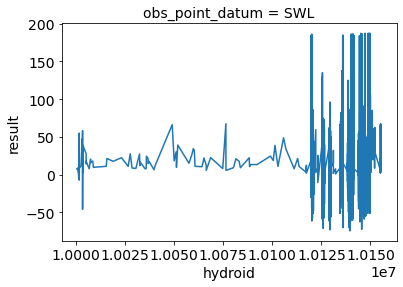

In [9]:
da_gw['result'].sel(obs_point_datum = 'SWL').mean('time').plot() #.drop(['time', 'obs_point_datum'])

In [2]:
%who

Interactive namespace is empty.


In [ ]:
df_gw = df_gw.reset_index()
df_gw = df_gw.set_index(['hydroid', 'obs_point_datum', 'time'])

# duplicate index values, https://stackoverflow.com/questions/54028365/what-does-this-mean-xarray-error-cannot-handle-a-non-unique-multi-index
df_gw = df_gw.groupby(level=df_gw.index.names).mean()
da_gw = df_gw.to_xarray()
da_gw

In [5]:
# subset wells that have data during the 2017-19 period
time_sel = slice('2017-01-01', '2019-12-31')
da_gw_drought = da_gw.sel(time = time_sel)
hy

<xarray.Dataset>
Dimensions:          (time: 3102901)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-01 2017-01-01 ... 2019-12-31
Data variables:
    hydroid          (time) int64 10148415 10147589 ... 10141111 10149677
    bore_id          (time) object 'GW025045.2.1' ... 'GW075027.2.2'
    data_owner       (time) object 'w00077' 'w00077' ... 'w00077' 'w00077'
    bore_date        (time) object '2017-01-01' '2017-01-01' ... '2019-12-31'
    obs_point_datum  (time) object 'SWL' 'SWL' 'SWL' ... 'DTW' 'SWL' 'SWL'
    result           (time) float64 26.59 26.59 26.59 165.1 ... 5.95 6.05 6.05
    quality_flag     (time) object 'quality-A' 'quality-A' ... 'quality-A'
    Longitude        (time) float64 149.5 149.5 149.5 ... 149.8 149.8 149.8
    Latitude         (time) float64 -30.16 -30.16 -30.16 ... -35.64 -35.64

In [20]:
da_gw_SWL = da_gw.where(da_gw['obs_point_datum'] == 'SWL')

In [23]:
df_gw_test = df_gw.reset_index()
df_gw_test.head()
#df_gw_test = df_gw_test.set_index(['hydroid', 'time'

,time,hydroid,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,Longitude,Latitude
0,1966-07-09,10129082,GW000001.1.1,w00077,1966-07-09 00:00:00,SWL,24.69,1,149.652012,-30.315324
1,1966-08-17,10129082,GW000001.1.1,w00077,1966-08-17 00:00:00,SWL,25.45,1,149.652012,-30.315324
2,1967-08-15,10129082,GW000001.1.1,w00077,1967-08-15 00:00:00,SWL,25.69,1,149.652012,-30.315324
3,1968-05-09,10129082,GW000001.1.1,w00077,1968-05-09 00:00:00,SWL,26.37,1,149.652012,-30.315324
4,1969-03-20,10129082,GW000001.1.1,w00077,1969-03-20 10:45:00,SWL,26.72,1,149.652012,-30.315324


In [25]:
df_gw['obs_point_datum'] == 'SWL'

time
1966-07-09    True
1966-08-17    True
1967-08-15    True
1968-05-09    True
1969-03-20    True
              ... 
2004-03-30    True
2004-03-31    True
2004-05-05    True
2004-05-03    True
2004-05-04    True
Name: obs_point_datum, Length: 19284403, dtype: bool

In [26]:
df_gw_swl = df_gw[df_gw['obs_point_datum'] == 'SWL']

In [28]:
df_gw_swl = df_gw_swl.reset_index()
df_gw_swl = df_gw_swl.set_index(['hydroid', 'time'])
df_gw_swl.head()

bore_id data_owner            bore_date  \
hydroid  time                                                       
10129082 1966-07-09  GW000001.1.1     w00077  1966-07-09 00:00:00   
         1966-08-17  GW000001.1.1     w00077  1966-08-17 00:00:00   
         1967-08-15  GW000001.1.1     w00077  1967-08-15 00:00:00   
         1968-05-09  GW000001.1.1     w00077  1968-05-09 00:00:00   
         1969-03-20  GW000001.1.1     w00077  1969-03-20 10:45:00   

                    obs_point_datum  result quality_flag   Longitude  \
hydroid  time                                                          
10129082 1966-07-09             SWL   24.69            1  149.652012   
         1966-08-17             SWL   25.45            1  149.652012   
         1967-08-15             SWL   25.69            1  149.652012   
         1968-05-09             SWL   26.37            1  149.652012   
         1969-03-20             SWL   26.72            1  149.652012   

                      Latitude  
hydroid  time                   
10129082 1966-07-09 -30.315324  
         1966-08-17 -30.315324  
         1967-08-15 -30.315324  
         1968-05-09 -30.315324  
         1969-03-20 -30.315324

In [60]:
# duplicate index values, https://stackoverflow.com/questions/54028365/what-does-this-mean-xarray-error-cannot-handle-a-non-unique-multi-index

df_gw_swl = df_gw_swl.groupby(level=df_gw_swl.index.names).mean()

In [63]:
df_gw_swl = df_gw_swl.to_xarray()

In [64]:
da_gw_swl = df_gw_swl
da_gw_swl

<xarray.Dataset>
Dimensions:    (hydroid: 9432, time: 21709)
Coordinates:
  * hydroid    (hydroid) int64 10000355 10000675 10001516 ... 10155417 10155529
  * time       (time) datetime64[ns] 1902-09-28 1905-01-24 ... 2021-10-14
Data variables:
    result     (hydroid, time) float64 nan nan nan nan nan ... nan nan nan nan
    Longitude  (hydroid, time) float64 nan nan nan nan nan ... nan nan nan nan
    Latitude   (hydroid, time) float64 nan nan nan nan nan ... nan nan nan nan

In [35]:
df_test = df_gw_swl[df_gw_swl.index.duplicated()]

In [36]:
len(df_gw_swl)

8322875

In [56]:
df_test.index

MultiIndex([(10148264, '2014-08-06'),
            (10147886, '2014-08-06'),
            (10139025, '2014-08-06'),
            (10148264, '2014-08-07'),
            (10147886, '2014-08-07'),
            (10139025, '2014-08-07'),
            (10148264, '2014-08-13'),
            (10147886, '2014-08-13'),
            (10139025, '2014-08-13'),
            (10148264, '2014-08-09'),
            ...
            (10003293, '2004-04-02'),
            (10003293, '2004-03-29'),
            (10003293, '2004-03-27'),
            (10003293, '2004-03-28'),
            (10003293, '2004-04-01'),
            (10003293, '2004-03-30'),
            (10003293, '2004-03-31'),
            (10003293, '2004-05-05'),
            (10003293, '2004-05-03'),
            (10003293, '2004-05-04')],
           names=['hydroid', 'time'], length=3380165)

In [51]:
df_gw_swl.loc?

Type:        property
String form: <property object at 0x7efd15e73720>
Docstring:  
Access a group of rows and columns by label(s) or a boolean array.

``.loc[]`` is primarily label based, but may also be used with a
boolean array.

Allowed inputs are:

- A single label, e.g. ``5`` or ``'a'``, (note that ``5`` is
  interpreted as a *label* of the index, and **never** as an
  integer position along the index).
- A list or array of labels, e.g. ``['a', 'b', 'c']``.
- A slice object with labels, e.g. ``'a':'f'``.

  .. warning:: Note that contrary to usual python slices, **both** the
      start and the stop are included

- A boolean array of the same length as the axis being sliced,
  e.g. ``[True, False, True]``.
- An alignable boolean Series. The index of the key will be aligned before
  masking.
- An alignable Index. The Index of the returned selection will be the input.
- A ``callable`` function with one argument (the calling Series or
  DataFrame) and that returns valid output for i

In [58]:
df_gw_swl.loc[(10003293, '2004-04-02')]#[df_gw_swl['time'] == '2014-08-06']

/local/zv2/ad9701/tmp/ipykernel_748169/2400048293.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_gw_swl.loc[(10003293, '2004-04-02')]#[df_gw_swl['time'] == '2014-08-06']


,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,Longitude,Latitude
time,,,,,,,,
2004-04-02,GW075010.1.1,w00077,2004-04-02,SWL,9.06,quality-A,150.10336,-30.81287
2004-04-02,GW075010.1.1,w00077,2004-04-02,SWL,9.06,quality-A,150.10336,-30.81287
2004-04-02,GW075010.1.1,w00077,2004-04-02,SWL,9.06,quality-A,150.10336,-30.81287


In [31]:
df_gw_swl.columns.value_counts()

bore_id            1
data_owner         1
bore_date          1
obs_point_datum    1
result             1
quality_flag       1
Longitude          1
Latitude           1
dtype: int64

In [33]:
df_gw = df_gw.reset_index()
df_gw = df_gw.set_index(['time', 'obs_point_datum'])

#### Multiindex does not work for some reason

In [37]:
df_gw = df_gw.reset_index()
df_gw = df_gw.set_index(['time'])

In [55]:
df_gw['time'] = df_gw['time'].apply(np.datetime64)

In [ ]:
df_gw = df_gw.set_index(['time'])

da_gw

In [19]:
df_gw = df_gw.reset_index(['hydroid'])

In [52]:
df_gw = df_gw.reset_index()

In [47]:
test_time = df_gw['bore_date'][0:5].values
test_time

array(['1966-07-09 00:00:00', '1966-08-17 00:00:00',
       '1967-08-15 00:00:00', '1968-05-09 00:00:00',
       '1969-03-20 10:45:00'], dtype=object)

In [51]:
np.datetime64(convert_to_date(test_time[0]))

numpy.datetime64('1966-07-09')

In [15]:
df_gw_sw = df_gw.set_index(['time'])

bore_id data_owner  \
hydroid  time       obs_point_datum                            
10129082 1966-07-09 SWL              GW000001.1.1     w00077   
         1966-08-17 SWL              GW000001.1.1     w00077   
         1967-08-15 SWL              GW000001.1.1     w00077   
         1968-05-09 SWL              GW000001.1.1     w00077   
         1969-03-20 SWL              GW000001.1.1     w00077   

                                               bore_date  result quality_flag  \
hydroid  time       obs_point_datum                                             
10129082 1966-07-09 SWL              1966-07-09 00:00:00   24.69            1   
         1966-08-17 SWL              1966-08-17 00:00:00   25.45            1   
         1967-08-15 SWL              1967-08-15 00:00:00   25.69            1   
         1968-05-09 SWL              1968-05-09 00:00:00   26.37            1   
         1969-03-20 SWL              1969-03-20 10:45:00   26.72            1   

                                      Longitude   Latitude  
hydroid  time       obs_point_datum                         
10129082 1966-07-09 SWL              149.652012 -30.315324  
         1966-08-17 SWL              149.652012 -30.315324  
         1967-08-15 SWL              149.652012 -30.315324  
         1968-05-09 SWL              149.652012 -30.315324  
         1969-03-20 SWL              149.652012 -30.315324

In [16]:
df_gw['result']

hydroid   time        obs_point_datum
10129082  1966-07-09  SWL                24.69
          1966-08-17  SWL                25.45
          1967-08-15  SWL                25.69
          1968-05-09  SWL                26.37
          1969-03-20  SWL                26.72
                                         ...  
10003293  2004-03-30  SWL                 8.93
          2004-03-31  SWL                 8.98
          2004-05-05  SWL                 9.06
          2004-05-03  SWL                 9.04
          2004-05-04  SWL                 9.06
Name: result, Length: 19284403, dtype: float64

In [10]:
df_gw.head()

bore_id data_owner  \
hydroid  time       obs_point_datum                            
10129082 1966-07-09 SWL              GW000001.1.1     w00077   
         1966-08-17 SWL              GW000001.1.1     w00077   
         1967-08-15 SWL              GW000001.1.1     w00077   
         1968-05-09 SWL              GW000001.1.1     w00077   
         1969-03-20 SWL              GW000001.1.1     w00077   

                                               bore_date  result quality_flag  \
hydroid  time       obs_point_datum                                             
10129082 1966-07-09 SWL              1966-07-09 00:00:00   24.69            1   
         1966-08-17 SWL              1966-08-17 00:00:00   25.45            1   
         1967-08-15 SWL              1967-08-15 00:00:00   25.69            1   
         1968-05-09 SWL              1968-05-09 00:00:00   26.37            1   
         1969-03-20 SWL              1969-03-20 10:45:00   26.72            1   

                                      Longitude   Latitude  
hydroid  time       obs_point_datum                         
10129082 1966-07-09 SWL              149.652012 -30.315324  
         1966-08-17 SWL              149.652012 -30.315324  
         1967-08-15 SWL              149.652012 -30.315324  
         1968-05-09 SWL              149.652012 -30.315324  
         1969-03-20 SWL              149.652012 -30.315324

### Get Latitude and Longitude data

In [61]:
df_bore

/local/zv2/ad9701/tmp/ipykernel_3943010/2560733565.py:2: DtypeWarning: Columns (46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bore = pd.read_csv(bore_select)


,HydroID,HydroCode,StateBoreI,StatePipeI,StateTerri,Agency,WCode,BoreDepth,DrilledDep,Status,...,LithLog,Hydrostrat,WaterLevel,Salinity,WaterCount,WaterDateM,WaterDat_1,SalinityCo,SalinityDa,Salinity_1
0,10148033,GW036283.3.1,GW036283,3.1,1,1,8,0.0,0.0,UNK,...,0,0,1,0,3,2017/02/07,2017/08/15,0,NaN,NaN
1,10148063,GW036211.1.1,GW036211,1.1,1,1,8,0.0,0.0,UNK,...,0,0,1,1,12795,1977/04/01,2021/09/27,16,2009/09/18,2014/07/29
2,10148320,GW087808.1.1,GW087808,1.1,1,1,8,0.0,0.0,UNK,...,0,0,1,1,3243,1999/04/15,2017/10/09,11,1997/01/10,2015/11/23
3,10148336,GW087747.1.1,GW087747,1.1,1,1,8,0.0,0.0,UNK,...,0,0,1,1,22527,1995/07/01,2021/07/14,54,1995/05/15,2016/08/24
4,10148340,GW087789.1.1,GW087789,1.1,1,1,8,0.0,0.0,UNK,...,0,0,1,1,1922,1999/04/13,2008/04/03,16,1998/05/29,2014/12/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116569,10147930,GW036880.2.1,GW036880,2.1,1,1,8,0.0,0.0,UNK,...,0,0,1,0,1,2017/05/16,2017/05/16,0,NaN,NaN
116570,10148220,GW030223.2.1,GW030223,2.1,1,1,8,0.0,0.0,UNK,...,0,0,1,0,4,2017/03/08,2018/01/04,0,NaN,NaN
116571,10148229,GW080414.1.1,GW080414,1.1,1,1,8,0.0,0.0,UNK,...,0,0,1,1,18102,2003/01/17,2021/03/05,23,2003/01/09,2012/08/29
116572,10147510,GW036766.2.2,GW036766,2.2,1,1,8,0.0,0.0,UNK,...,0,0,1,0,6075,1988/06/22,2019/02/13,0,NaN,NaN


In [64]:
np.unique(df_bore['WaterLevel'])

array([0, 1])

/local/zv2/ad9701/tmp/ipykernel_3943010/2983944318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gw['Longitude'] = df_gw['hydroid'].map(df_bore.set_index('HydroID')['Longitude'])


/local/zv2/ad9701/tmp/ipykernel_3943010/3056163756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gw['Latitude'] = df_gw['hydroid'].map(df_bore.set_index('HydroID')['Latitude'])


In [107]:
[convert_to_date(x) for x in df_gw['bore_date']]

KeyboardInterrupt: 

In [110]:
len(df_gw)

21311054

In [126]:

df_gw = df_gw.set_index(['hydroid', 'time', 'obs_point_datum'])

KeyboardInterrupt: 

In [136]:
df_gw

bore_id data_owner  \
hydroid  time       obs_point_datum                            
10129082 1966-07-09 SWL              GW000001.1.1     w00077   
         1966-08-17 SWL              GW000001.1.1     w00077   
         1967-08-15 SWL              GW000001.1.1     w00077   
         1968-05-09 SWL              GW000001.1.1     w00077   
         1969-03-20 SWL              GW000001.1.1     w00077   
...                                           ...        ...   
10149675 2011-02-08 SWL              GW075012.1.1     w00077   
10149730 2011-02-08 SWL              GW075012.1.1     w00077   
10130019 2011-02-08 SWL              GW075012.1.1     w00077   
10149675 2011-02-09 DTW              GW075012.1.1     w00077   
10149730 2011-02-09 DTW              GW075012.1.1     w00077   

                                               bore_date  result quality_flag  \
hydroid  time       obs_point_datum                                             
10129082 1966-07-09 SWL              1966-07-09 00:00:00   24.69            1   
         1966-08-17 SWL              1966-08-17 00:00:00   25.45            1   
         1967-08-15 SWL              1967-08-15 00:00:00   25.69            1   
         1968-05-09 SWL              1968-05-09 00:00:00   26.37            1   
         1969-03-20 SWL              1969-03-20 10:45:00   26.72            1   
...                                                  ...     ...          ...   
10149675 2011-02-08 SWL                       2011-02-08   12.64    quality-A   
10149730 2011-02-08 SWL                       2011-02-08   12.64    quality-A   
10130019 2011-02-08 SWL                       2011-02-08   12.64    quality-A   
10149675 2011-02-09 DTW                       2011-02-09   11.66    quality-A   
10149730 2011-02-09 DTW                       2011-02-09   11.66    quality-A   

                                      Latitude   Longitude  
hydroid  time       obs_point_datum                         
10129082 1966-07-09 SWL             -30.315324  149.652012  
         1966-08-17 SWL             -30.315324  149.652012  
         1967-08-15 SWL             -30.315324  149.652012  
         1968-05-09 SWL             -30.315324  149.652012  
         1969-03-20 SWL             -30.315324  149.652012  
...                                        ...         ...  
10149675 2011-02-08 SWL                    NaN         NaN  
10149730 2011-02-08 SWL                    NaN         NaN  
10130019 2011-02-08 SWL                    NaN         NaN  
10149675 2011-02-09 DTW                    NaN         NaN  
10149730 2011-02-09 DTW                    NaN         NaN  

[21311054 rows x 7 columns]

In [135]:
da_gw

<xarray.Dataset>
Dimensions:          (index: 21311054)
Coordinates:
  * index            (index) int64 0 1 2 3 ... 35084099 35084100 35084101
Data variables:
    hydroid          (index) int64 10129082 10129082 ... 10149675 10149730
    bore_id          (index) object 'GW000001.1.1' ... 'GW075012.1.1'
    data_owner       (index) object 'w00077' 'w00077' ... 'w00077' 'w00077'
    bore_date        (index) object '1966-07-09 00:00:00' ... '2011-02-09'
    obs_point_datum  (index) object 'SWL' 'SWL' 'SWL' ... 'SWL' 'DTW' 'DTW'
    result           (index) float64 24.69 25.45 25.69 ... 12.64 11.66 11.66
    quality_flag     (index) object '1' '1' '1' ... 'quality-A' 'quality-A'
    Latitude         (index) float64 -30.32 -30.32 -30.32 -30.32 ... nan nan nan
    Longitude        (index) float64 149.7 149.7 149.7 149.7 ... nan nan nan nan
    time             (index) object 1966-07-09 1966-08-17 ... 2011-02-09

In [133]:
outnc = 
da_gw

<xarray.Dataset>
Dimensions:          (index: 21311054)
Coordinates:
  * index            (index) int64 0 1 2 3 ... 35084099 35084100 35084101
Data variables:
    hydroid          (index) int64 10129082 10129082 ... 10149675 10149730
    bore_id          (index) object 'GW000001.1.1' ... 'GW075012.1.1'
    data_owner       (index) object 'w00077' 'w00077' ... 'w00077' 'w00077'
    bore_date        (index) object '1966-07-09 00:00:00' ... '2011-02-09'
    obs_point_datum  (index) object 'SWL' 'SWL' 'SWL' ... 'SWL' 'DTW' 'DTW'
    result           (index) float64 24.69 25.45 25.69 ... 12.64 11.66 11.66
    quality_flag     (index) object '1' '1' '1' ... 'quality-A' 'quality-A'
    Latitude         (index) float64 -30.32 -30.32 -30.32 -30.32 ... nan nan nan
    Longitude        (index) float64 149.7 149.7 149.7 149.7 ... nan nan nan nan
    time             (index) object 1966-07-09 1966-08-17 ... 2011-02-09

In [118]:
xx = df_gw.groupby('hydroid')['obs_point_datum'].nunique()

In [129]:
df_gw.head()

,hydroid,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,Latitude,Longitude,time
0,10129082,GW000001.1.1,w00077,1966-07-09 00:00:00,SWL,24.69,1,-30.315324,149.652012,1966-07-09
1,10129082,GW000001.1.1,w00077,1966-08-17 00:00:00,SWL,25.45,1,-30.315324,149.652012,1966-08-17
2,10129082,GW000001.1.1,w00077,1967-08-15 00:00:00,SWL,25.69,1,-30.315324,149.652012,1967-08-15
3,10129082,GW000001.1.1,w00077,1968-05-09 00:00:00,SWL,26.37,1,-30.315324,149.652012,1968-05-09
4,10129082,GW000001.1.1,w00077,1969-03-20 10:45:00,SWL,26.72,1,-30.315324,149.652012,1969-03-20


In [122]:
df_gw[df_gw['hydroid']==10001519]

,hydroid,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag,Latitude,Longitude
22457080,10001519,GW090016.2.2,w00077,2001-03-07,SWL,6.27,quality-A,-33.265877,148.75818
22457081,10001519,GW090016.2.2,w00077,2001-03-07,RSWL (mAHD),449.42,quality-A,-33.265877,148.75818
22457082,10001519,GW090016.2.2,w00077,2001-03-07,DTW,5.27,quality-A,-33.265877,148.75818
22457083,10001519,GW090016.2.2,w00077,2001-02-12,SWL,6.37,quality-A,-33.265877,148.75818
22457084,10001519,GW090016.2.2,w00077,2001-02-12,RSWL (mAHD),449.32,quality-A,-33.265877,148.75818
...,...,...,...,...,...,...,...,...,...
23628090,10001519,GW090016.2.2,w00077,2017-10-16,SWL,5.89,quality-A,-33.265877,148.75818
23628091,10001519,GW090016.2.2,w00077,2017-10-16,DTW,4.89,quality-A,-33.265877,148.75818
23628092,10001519,GW090016.2.2,w00077,2017-10-16,RSWL (mAHD),449.80,quality-A,-33.265877,148.75818
23628094,10001519,GW090016.2.2,w00077,2018-01-23,RSWL (mAHD),449.40,quality-A,-33.265877,148.75818


In [ ]:
ds_gw = df_gw.to_xarray()

In [82]:
pd.unique(df_gw['obs_point_datum'])

array(['SWL', 'RSWL (mAHD)', 'DTW'], dtype=object)

In [58]:
pd.unique(df_gw['quality_flag'])

array(['1', 'quality-A', nan], dtype=object)

In [91]:
len(df_gw['bore_date'][0])

19

In [92]:
df_gw['bore_date'][0]

'1966-07-09 00:00:00'

In [6]:
hydroid = df_gw['hydroid']

In [10]:
uniq_hydroid = np.unique(df_gw['hydroid'])

In [12]:
len(uniq_hydroid)

10415

In [13]:
boreid = df_gw['bore_id']

In [14]:
uniq_boreid = np.unique(df_gw['bore_id'])

In [15]:
len(uniq_boreid)

8649

In [16]:
df_gw_subset = df_gw[df_gw['hydroid']==10129082]

In [17]:
df_gw_subset

,hydroid,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag
0,10129082,GW000001.1.1,w00077,1966-07-09 00:00:00,SWL,24.69,1
1,10129082,GW000001.1.1,w00077,1966-08-17 00:00:00,SWL,25.45,1
2,10129082,GW000001.1.1,w00077,1967-08-15 00:00:00,SWL,25.69,1
3,10129082,GW000001.1.1,w00077,1968-05-09 00:00:00,SWL,26.37,1
4,10129082,GW000001.1.1,w00077,1969-03-20 10:45:00,SWL,26.72,1
...,...,...,...,...,...,...,...
16323843,10129082,GW000001.1.1,w00077,1971-04-28 14:05:00,SWL,26.88,1
16323844,10129082,GW000001.1.1,w00077,1968-11-07 00:00:00,SWL,23.53,1
16323845,10129082,GW000001.1.1,w00077,1968-04-05 00:00:00,SWL,26.33,1
16323846,10129082,GW000001.1.1,w00077,1969-01-15 11:25:00,SWL,26.34,1


In [21]:
df_gw_subset2 = df_gw[df_gw['bore_id']=='GW000001.1.1']

In [22]:
df_gw_subset2

,hydroid,bore_id,data_owner,bore_date,obs_point_datum,result,quality_flag
0,10129082,GW000001.1.1,w00077,1966-07-09 00:00:00,SWL,24.69,1
1,10129082,GW000001.1.1,w00077,1966-08-17 00:00:00,SWL,25.45,1
2,10129082,GW000001.1.1,w00077,1967-08-15 00:00:00,SWL,25.69,1
3,10129082,GW000001.1.1,w00077,1968-05-09 00:00:00,SWL,26.37,1
4,10129082,GW000001.1.1,w00077,1969-03-20 10:45:00,SWL,26.72,1
...,...,...,...,...,...,...,...
16323843,10129082,GW000001.1.1,w00077,1971-04-28 14:05:00,SWL,26.88,1
16323844,10129082,GW000001.1.1,w00077,1968-11-07 00:00:00,SWL,23.53,1
16323845,10129082,GW000001.1.1,w00077,1968-04-05 00:00:00,SWL,26.33,1
16323846,10129082,GW000001.1.1,w00077,1969-01-15 11:25:00,SWL,26.34,1


In [24]:
df_gw_subset.equals(df_gw_subset2)

True

### Sometimes the bore_id is not unique for each hydroid!
### why?

In [28]:
df = df_gw.groupby('bore_id')['hydroid'].nunique()
df

bore_id
GW000001.1.1    1
GW000021.1.1    1
GW000120.1.1    1
GW000133.1.1    1
GW000183.1.1    1
               ..
GW969015.1.1    3
GW970321.1.1    3
GW970322.1.1    3
GW970323.1.1    3
GW971623.3.3    2
Name: hydroid, Length: 8649, dtype: int64

In [29]:
df[df>1]

bore_id
GW004023.1.1    3
GW004549.1.1    3
GW004598.1.1    3
GW012314.1.1    3
GW021266.3.1    2
               ..
GW969015.1.1    3
GW970321.1.1    3
GW970322.1.1    3
GW970323.1.1    3
GW971623.3.3    2
Name: hydroid, Length: 1128, dtype: int64

In [25]:
list_boreid = []
list_hydroid = []
for b in uniq_boreid:
    hydroid_temp = df_gw[df_gw['bore_id']==b]['hydroid']
    if len(hydroid_temp) > 1:
        list_boreid.append(b)
        list_hydroid.append(hydroid_temp)

KeyboardInterrupt: 

In [26]:
len(list_boreid)

1543

In [38]:
out_csv = 'example_boreid_multiple_hydroid.csv'
df_gw[df_gw['bore_id']=='GW004023.1.1'].to_csv(out_csv)

In [39]:
uniq_hydroid

array([10000355, 10000675, 10001513, ..., 10155414, 10155417, 10155529])

In [40]:
uniq_boreid

array(['GW000001.1.1', 'GW000021.1.1', 'GW000120.1.1', ...,
       'GW970322.1.1', 'GW970323.1.1', 'GW971623.3.3'], dtype=object)

In [52]:
xx=df_nsw_bore[df_nsw_bore['HydroID']==uniq_hydroid[2]]

In [54]:
xx.columns

Index(['HydroID', 'HydroCode', 'StateBoreI', 'StatePipeI', 'StateTerri',
       'Agency', 'WCode', 'BoreDepth', 'DrilledDep', 'Status', 'DrilledDat',
       'HGUID', 'HGUNumber', 'HGUName', 'NafHGUNumb', 'AquiferTyp', 'FType',
       'Latitude', 'Longitude', 'Easting', 'Northing', 'Projection',
       'Projecti_1', 'CoordMetho', 'HeightDatu', 'RefElev', 'RefElevDes',
       'RefElevMet', 'TsRefElev', 'TsRefElevD', 'TsRefElevM', 'LandElev',
       'LandElevMe', 'IsMultiPip', 'BoreLineCo', 'WorksID', 'LicenceExt',
       'LicenceE_1', 'LicenceUse', 'FTypeClass', 'Constructi', 'LithLog',
       'Hydrostrat', 'WaterLevel', 'Salinity', 'WaterCount', 'WaterDateM',
       'WaterDat_1', 'SalinityCo', 'SalinityDa', 'Salinity_1'],
      dtype='object')

In [51]:
len(df_nsw_bore)

116574